In [2]:
import os
import sys
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [3]:
notebooks = os.path.abspath('')
src = os.path.dirname(notebooks)
if not src in sys.path: 
    sys.path.append(src)

In [4]:
from helpers import get_emotion_abrs_from_ids

# Paths

In [5]:
output_path = '../../files/out/video/'
# Global configuration path
glob_conf_path = '../global_config.py'

# Load global variables

In [6]:
exec(open(glob_conf_path).read())

# Parameters

In [7]:
threads = -26

# Load and shuffle data

In [8]:
from sklearn.utils import shuffle

train_intensity_df = pd.read_csv(output_path + 'video_data_intensity_train.csv')
train_shuffled_df = shuffle(train_intensity_df, random_state=seed)
train_shuffled_df

,filename,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,...,AU45_r_mean,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,video_id,emotion_1_id,group
2390,A201_sad_p_3,0.085853,0.347717,0.0,0.05,0.068548,0.068548,0.144231,0.099202,0.286747,...,0.479884,0.206857,0.0,0.000000,0.408359,0.408359,0.099010,A201,6,3
2146,A201_bor_v_3,0.409475,0.199905,0.0,0.00,0.368548,0.368548,0.096154,0.141613,0.256958,...,0.234310,0.369600,0.0,0.000000,0.087070,0.087070,0.039604,A201,26,3
9213,A65_nos_p_2,0.058515,0.596365,0.0,0.15,0.016129,0.016129,0.067308,0.055337,0.258642,...,0.050793,0.253234,0.0,0.111111,0.030475,0.030475,0.099010,A65,30,4
5516,A26_reg_v_1,0.106750,0.376186,0.0,0.15,0.072581,0.072581,0.105769,0.112120,0.368763,...,0.631815,0.195240,0.0,0.000000,0.568132,0.568132,0.079208,A26,0,1
10588,A75_nos_p_4,0.117903,0.514505,0.0,0.10,0.030645,0.030645,0.009615,0.137451,0.312158,...,0.088909,0.230322,0.0,0.111111,0.082717,0.082717,0.049505,A75,30,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7192,A334_neu_sit3_v,0.022987,0.384122,0.0,0.05,0.012097,0.012097,0.144231,0.022790,0.264834,...,0.238276,0.308160,0.0,0.000000,0.093165,0.093165,0.069307,A334,22,10
4848,A223_sar_v_1,0.085952,0.370207,0.0,0.05,0.070565,0.070565,0.211538,0.030387,0.303431,...,0.120496,0.706075,0.0,0.055556,0.023944,0.023944,0.079208,A223,31,10
3912,A220_conf_v_1,0.020227,0.148694,0.0,0.20,0.014113,0.014113,0.105769,0.046551,0.180510,...,0.016536,0.149081,0.0,0.083333,0.017414,0.017414,0.079208,A220,1,11
3768,A21_reg_v_1,0.066944,0.245488,0.0,0.00,0.050403,0.050403,0.086538,0.066539,0.320183,...,0.027456,0.205459,0.0,0.111111,0.018285,0.018285,0.099010,A21,0,5


# Other functions

In [9]:
from sklearn.metrics import confusion_matrix

def calculate_conf_matrix(X_train, X_val, y_train, y_val, clf):
    # train classifier on training sets 
    clf.fit(X_train,y_train)

    # Compute results (validation dataset)    
    y_pred = clf.predict(X_val)                       # Predict class

    # compare true validation results (y_val) with prediction (y_pred)
    # Compute confusion matrix
    return confusion_matrix(y_val,
                            y_pred,
                            normalize='true'
                            )
    

In [10]:
def iterate_conf_matrices(size, X, y, cv, clf):
    # Initialize a matrix of zeros to store results
    conf_mat_avg = np.zeros([size, size])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        conf_mat_avg += calculate_conf_matrix(X_train, X_val, y_train, y_val, clf)
    
    # compute the average scores by dividing with number of groups
    return conf_mat_avg/n_groups

In [11]:
def get_conf_matrix(X, y, cv, clf):
    """
    Produces a confusion matrix by iterating and averageing the confusion matrix for each validation set
    :return: confusion matrix in the form of a dataframe
    """
    # get emotion_ids
    emotion_ids = y.unique()
    
    # compute the average scores by dividing with number of groups
    conf_mat_avg = iterate_conf_matrices(len(emotion_ids), X, y, cv, clf,)
    
    # get emotion abreviations
    emotion_abrs = get_emotion_abrs_from_ids(emotion_ids)
    
    # create dataframe with lists of emotion ids as row and column names
    df_cm = pd.DataFrame(conf_mat_avg, list(emotion_abrs), list(emotion_abrs))
    
    # sort columns
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    return df_cm

In [12]:
def plot_conf_matrix(df_cm, title):
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)

In [13]:
def save_conf_matrix(file_name):
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')       

# Training and testing

### Get X, y and groups from the training data set

In [14]:
# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=["filename", "video_id", "emotion_1_id", "group"])
y = train_shuffled_df.emotion_1_id
groups = train_shuffled_df.group
n_groups = len(groups.unique())

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Define parameters to evaluate
# the number of trees to build before taking the maximum voting or averages of predictions
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
class_weight_values      = ['balanced']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters      = {'n_estimators': n_estimators_values,
                   'criterion': criterion_values,
                   'max_features': max_features_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'bootstrap': bootstrap_values,
                   'random_state': [seed],
                   'class_weight': class_weight_values,
                   'n_jobs': [threads]
                  }

rf = RandomForestClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = rf, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         n_iter              = 5000,
                         random_state        = seed,
                         n_jobs              = threads,
                         pre_dispatch = 'n_jobs'
                        )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_rf_'+str(n_groups)+'_logocv_intensity_video.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_rf_intensity_video.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_rf_intensity_video.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 4320 is smaller than n_iter=5000. Running 4320 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 4320 candidates, totalling 8640 fits
RandomForestClassifier(class_weight='balanced', max_depth=60,
                       max_features='sqrt', min_samples_leaf=2,
                       n_estimators=282, n_jobs=-1, random_state=27)


[Parallel(n_jobs=-26)]: Using backend LokyBackend with 27 concurrent workers.
[Parallel(n_jobs=-26)]: Done   7 out of  16 | elapsed:   30.1s remaining:   38.7s
[Parallel(n_jobs=-26)]: Done  16 out of  16 | elapsed:   30.5s finished
[Parallel(n_jobs=-26)]: Using backend LokyBackend with 27 concurrent workers.


AUC_avg (train): 0.9837461565228929
AUC_std (train): 0.0005621552497455342
AUC_avg (validation): 0.7469379051645155
AUC_std (validation): 0.03573824894415437


[Parallel(n_jobs=-26)]: Done   7 out of  16 | elapsed:   25.8s remaining:   33.2s
[Parallel(n_jobs=-26)]: Done  16 out of  16 | elapsed:   26.2s finished


UAR_avg (train): 0.7956871619483694
UAR_std (train): 0.004805048388135836
UAR_avg (validation): 0.09333730883185129
UAR_std (validation): 0.02133008165392025


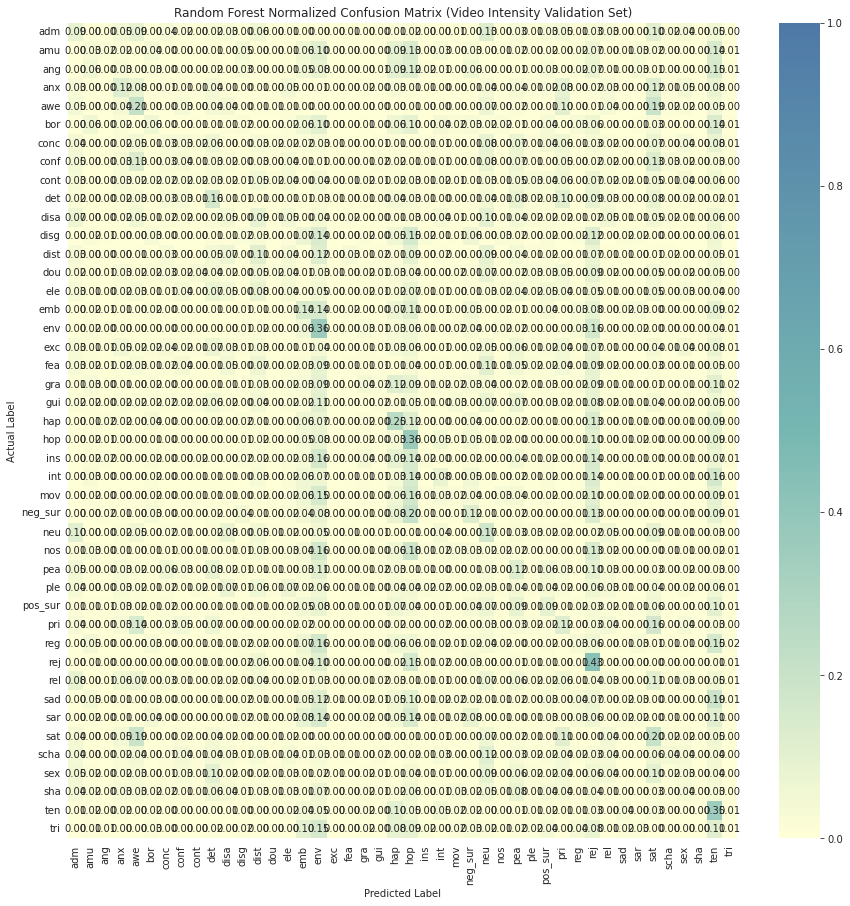

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_rf_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = RandomForestClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = threads,
                        pre_dispatch = 'n_jobs',
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = threads,
                        pre_dispatch = 'n_jobs',
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Random Forest Normalized Confusion Matrix (Video Intensity Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_rf_intensity_video.svg')

In [19]:
clf.feature_names_in_

array(['AU01_r_mean', 'AU01_r_stddevNorm', 'AU01_r_percentile20.0',
       'AU01_r_percentile50.0', 'AU01_r_percentile80.0',
       'AU01_r_iqr60_80-20', 'AU01_r_numPeaks', 'AU02_r_mean',
       'AU02_r_stddevNorm', 'AU02_r_percentile20.0',
       'AU02_r_percentile50.0', 'AU02_r_percentile80.0',
       'AU02_r_iqr60_80-20', 'AU02_r_numPeaks', 'AU04_r_mean',
       'AU04_r_stddevNorm', 'AU04_r_percentile20.0',
       'AU04_r_percentile50.0', 'AU04_r_percentile80.0',
       'AU04_r_iqr60_80-20', 'AU04_r_numPeaks', 'AU05_r_mean',
       'AU05_r_stddevNorm', 'AU05_r_percentile20.0',
       'AU05_r_percentile50.0', 'AU05_r_percentile80.0',
       'AU05_r_iqr60_80-20', 'AU05_r_numPeaks', 'AU06_r_mean',
       'AU06_r_stddevNorm', 'AU06_r_percentile20.0',
       'AU06_r_percentile50.0', 'AU06_r_percentile80.0',
       'AU06_r_iqr60_80-20', 'AU06_r_numPeaks', 'AU07_r_mean',
       'AU07_r_stddevNorm', 'AU07_r_percentile20.0',
       'AU07_r_percentile50.0', 'AU07_r_percentile80.0',
       'AU